In [1]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

In [2]:
pd.__version__

'2.2.1'

In [3]:
RANDOM_STATE = 42

## 1. Prepare data

### Merge 3 data frames into single one by abon_id

In [15]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

def prepare_related_data(columns: list, index_column: str, df: pd.DataFrame) -> pd.DataFrame:
    """
    Related data will be processed in the same way:
    - group by `index_column`
    - sum all columns
    - apply log1p to all columns except `index_column`
    """
    col_to_fetch = columns + [index_column]
    res = df[col_to_fetch].groupby(index_column).sum()
    res = res[columns].apply(np.log1p)
    return res


def prepare_data(train: pd.DataFrame, dpi: pd.DataFrame, bnum: pd.DataFrame) -> pd.DataFrame:
    """
    Prepare data for training
    """
    dpi_columns = ['SUM_of_Duration_sec','SUM_of_Volume_kb','SUM_of_Count_events','MAX_of_day_cnt']
    dpi_index_column = 'abon_id'

    bnum_columns = ['call_cnt_out','call_cnt_in','call_dur_out','call_dur_in','cnt_sms_out','cnt_sms_in']
    bnum_index_column = 'abon_id'

    df_train_dpi_agg = prepare_related_data(dpi_columns, dpi_index_column, dpi)
    df_train_bnum_agg = prepare_related_data(bnum_columns, bnum_index_column, bnum)
    # let's merge all dataframes
    # merge bnum dataframe
    df_train = train.merge(df_train_bnum_agg, on='abon_id', how='left')

    # merge dpi dataframe
    df_train = df_train.merge(df_train_dpi_agg, on='abon_id', how='left')

    # fill missings for dpi_columns, bnum_columns
    df_train.fillna({col: df_train[col].median() for col in dpi_columns + bnum_columns}, inplace=True)
    return df_train


# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)


def get_score(df_train: pd.DataFrame, target_column: str = 'target') -> float:
    """
    Get score for the given dataframes
    """
    acopy = df_train.copy()
    X, y = acopy.drop(target_column, axis=1), acopy[target_column]
    X_train, X_val, y_train, y_val= train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

    return score_dataset(X_train, X_val, y_train, y_val)


def get_feature_importance(df_train: pd.DataFrame =  None, target_column: str = 'target', estimator=RandomForestRegressor) -> pd.DataFrame:
    """
    Get feature importance for the given dataframes
    """
    acopy = df_train.copy()
    X, y = acopy.drop(target_column, axis=1), acopy[target_column]
    return estimate_feature_importance(X, y, estimator)


def estimate_feature_importance(X, y, estimator) -> pd.DataFrame:
    model = estimator(random_state=RANDOM_STATE)
    model.fit(X, y)
    return pd.DataFrame(data=model.feature_importances_, index=X.columns, columns=['importance']).sort_values(by='importance', ascending=False)


def drop_columns_with_nulls(frame: pd.DataFrame, threshold: float = 0.7) -> pd.DataFrame:
    """
    Drop columns with more than threshold % of nulls
    """
    return frame.dropna(thresh=threshold*frame.shape[0], axis=1)



def impute_dataset(X, y) -> pd.DataFrame:
    """
    Impute dataset
    """
    simple_impute = SimpleImputer(missing_values=np.nan, add_indicator=True, strategy='constant', fill_value=0)
    imputed = simple_impute.fit_transform(X, y)
    # Extract the indicator columns
    indicator = simple_impute.indicator_
    indicator_columns = indicator.get_feature_names_out(input_features=X.columns)
    # Reconstruct the DataFrame with the original columns and indicator columns
    new_columns = list(X.columns) + list(indicator_columns)
    return pd.DataFrame(imputed, columns=new_columns, index=X.index)



## Dataset scoring

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

def prepare_related_data(columns: list, index_column: str, df: pd.DataFrame) -> pd.DataFrame:
    """
    Related data will be processed in the same way:
    - group by `index_column`
    - sum all columns
    - apply log1p to all columns except `index_column`
    """
    col_to_fetch = columns + [index_column]
    res = df[col_to_fetch].groupby(index_column).sum()
    res = res[columns].apply(np.log1p)
    return res


# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)


def get_score(df_train: pd.DataFrame, target_column: str = 'target') -> float:
    """
    Get score for the given dataframes
    """
    acopy = df_train.copy()
    X, y = acopy.drop(target_column, axis=1), acopy[target_column]
    X_train, X_val, y_train, y_val= train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

    return score_dataset(X_train, X_val, y_train, y_val)


def get_feature_importance(df_train: pd.DataFrame =  None, target_column: str = 'target', estimator=RandomForestRegressor) -> pd.DataFrame:
    """
    Get feature importance for the given dataframes
    """
    acopy = df_train.copy()
    X, y = acopy.drop(target_column, axis=1), acopy[target_column]
    return estimate_feature_importance(X, y, estimator)


def estimate_feature_importance(X, y, estimator) -> pd.DataFrame:
    model = estimator(random_state=RANDOM_STATE)
    model.fit(X, y)
    return pd.DataFrame(data=model.feature_importances_, index=X.columns, columns=['importance']).sort_values(by='importance', ascending=False)

def scale_features(X: pd.DataFrame) -> pd.DataFrame:
    """
    Scale features
    """
    return X
    # from sklearn.preprocessing import StandardScaler
    # scaler = StandardScaler()
    # return pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)


def prepare_dataset(train: pd.DataFrame, dpi: pd.DataFrame, bnum: pd.DataFrame, features: list[str] | None = None) -> tuple[pd.DataFrame, pd.Series]:
    """
    Prepare dataset for training
    """
    dataset = prepare_data(train, dpi, bnum)
    if features:
        # if features are provided, we will use only them
        X, y = dataset.drop('target', axis=1), dataset['target']
        X_imputed = impute_dataset(X, y)
        X_scaled = scale_features(X_imputed[features])
        return X_scaled[features], y
    else:
        df_train_nulls_removed = drop_columns_with_nulls(dataset)
        X, y = df_train_nulls_removed.drop('target', axis=1), df_train_nulls_removed['target']
        X_imputed = impute_dataset(X, y)
        X_scaled = scale_features(X_imputed)
        return X_scaled, y

## FEATURE SELECTION

# SK learn FEATURE selection 

from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.inspection import permutation_importance
# ligtgbm features
import lightgbm as lgb
import xgboost as xgb
from functools  import partial


# model parameters tuning
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from skopt.searchcv import BayesSearchCV


def get_low_variance_features(X: pd.DataFrame, y:  pd.Series, threshold: float = 0.8, **kwargs) -> pd.DataFrame:
    """
    Get features with low variance
    """
    sel = VarianceThreshold(threshold=(threshold * (1 - threshold)))
    sel.fit_transform(X, y)
    return X.columns[sel.get_support(indices=True)].to_list()


# using KBEST
def get_k_best_features(X: pd.DataFrame, y: pd.Series, k: int = 200, **kwargs) -> pd.DataFrame:
    """
    Get K best features
    """
    selection_method = SelectKBest(f_classif, k=k)
    selection_method.fit_transform(X, y)
    return X.columns[selection_method.get_support(indices=True)].to_list()


# select from model
def get_features_from_model(X: pd.DataFrame, y: pd.Series, **kwargs) -> list[str]:
    """
    Get features from model
    """

    model = SelectFromModel(
        estimator=ExtraTreesClassifier(n_estimators=50).fit(X, y), 
        prefit=True
    )
    model.transform(X)
    return X.columns[model.get_support(indices=True)].to_list()


def get_xgboos_features(X: pd.DataFrame, y: pd.Series, threshold: float=0.0018, **kwargs) -> list[str]:
    """
    Get features from using XGBoost
    """

    model = partial(xgb.XGBModel, objective='binary:logistic') 
    features = estimate_feature_importance(X, y, model)
    return features.abs()[features.importance>threshold].index.tolist()


def get_lgbm_features(X: pd.DataFrame, y: pd.Series, importance_type: str = 'gain', importance=3, **kwargs) -> list[str]:
    """
    Get features from using LightGBM
    """
    lgb_features = estimate_feature_importance(X, y, partial(lgb.LGBMClassifier, importance_type=importance_type))
    return lgb_features[lgb_features.importance > importance].index.to_list()


def get_correlation_features(X: pd.DataFrame, y: pd.Series,  threshold=0.1, **kwargs) -> list[str]:
    """
    Get features from using correlation
    """
    corr = X.corrwith(y)
    
    return corr[abs(corr) > threshold].index.to_list()


def get_rfe_features(X: pd.DataFrame, y: pd.Series, n_features_to_select=200, **kwargs) -> list[str]:
    """
    Get features from using RFE
    """
    from sklearn.feature_selection import RFE
    rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=n_features_to_select, verbose=1)
    rfe.fit(X, y)
    return X.columns[rfe.support_].to_list()


def get_lasso_features(X: pd.DataFrame, y: pd.Series, alpha=0.1, **kwargs) -> list[str]:
    """
    Get features from using Lasso
    """
    from sklearn.linear_model import Lasso
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    importance = np.abs(lasso.coef_)
    selected_features = np.where(importance > 0)[0]
    return X.columns[selected_features].to_list()


def get_features_by_permutation(X: pd.DataFrame, y: pd.Series, X_val:  pd.DataFrame, y_val: pd.DataFrame) -> list[str]:
    # feature permutation
    model =  lgb.LGBMClassifier(random_state=RANDOM_STATE)

    lgbm_features  = get_lgbm_features(55)

    X_test_lgbm = X_val[lgbm_features]
    X_train_lgbm = X[lgbm_features]

    _, X_test, _, y_test = train_test_split(X_test_lgbm, y_val, test_size=0.2)

    model.fit(X_train_lgbm, y)
    r = permutation_importance(model, X_test, y_test,
                            n_repeats=30,
                            random_state=0)
    res  = {}
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print(f"{X_train_lgbm.columns[i]:<8}"
                f"{r.importances_mean[i]:.3f}"
                f" +/- {r.importances_std[i]:.3f}")
            res[X_train_lgbm.columns[i]]  = r.importances_mean[i]


def find_params_xgboost(X: pd.DataFrame, y: pd.DataFrame, eval_metric='auc') -> BayesSearchCV:
    xgb_search_space  = {
        'n_estimators': Integer(50, 1000),
        'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'max_depth': Integer(3, 10),
        'min_child_weight': Integer(1, 10),
        'gamma': Real(0, 0.5),
        'subsample': Real(0.6, 1.0, prior='uniform'),
        'colsample_bytree': Real(0.6, 1.0, prior='uniform'),
        'reg_alpha': Real(0.01, 1.0, prior='log-uniform'),
        'reg_lambda': Real(0.01, 1.0, prior='log-uniform'),
        'scale_pos_weight': Real(1.0, 10.0, prior='uniform')
    }
    xgb_bayes_cv = BayesSearchCV(
        estimator=xgb.XGBClassifier(
            use_label_encoder=False, random_state=RANDOM_STATE,
            **(dict(eval_metric=eval_metric) if eval_metric else {})
        ),
        search_spaces=xgb_search_space,
        n_iter=32,
        cv=3,
        n_jobs=-1,
        verbose=0,
        random_state=RANDOM_STATE
    )
    xgb_bayes_cv.fit(X, y)
    return xgb_bayes_cv


def find_params_rfc(X: pd.DataFrame, y: pd.DataFrame) -> BayesSearchCV:
    rf_search_space = {
        'n_estimators': Integer(50, 200),
        'max_depth': Integer(3, 20),
        'min_samples_split': Integer(2, 20),
        'min_samples_leaf': Integer(1, 20),
        'bootstrap': [True, False]
    }
    rf_bayes_cv = BayesSearchCV(
        estimator=RandomForestClassifier(random_state=RANDOM_STATE, criterion='gini'),
        search_spaces=rf_search_space,
        n_iter=32,
        cv=3,
        n_jobs=-1,
        verbose=0,
        random_state=RANDOM_STATE
    )
    rf_bayes_cv.fit(X, y)
    return rf_bayes_cv


def find_params_lgbmc(X: pd.DataFrame, y: pd.DataFrame, metric: str|None = None, lgbmc_kwargs: dict | None = None) -> BayesSearchCV:
    lgbm_search_space  = {
        'num_leaves': Integer(31, 150),
        'learning_rate': Real(0.01, 0.2, prior='log-uniform'),
        'n_estimators': Integer(100, 1000),
        'max_depth': Integer(-1, 20),
        'min_child_samples': Integer(10, 100),
        'subsample': Real(0.6, 1.0, prior='uniform'),
        'colsample_bytree': Real(0.6, 1.0, prior='uniform'),
        'reg_alpha': Real(0.0, 1.0, prior='uniform'),
        'reg_lambda': Real(0.0, 1.0, prior='uniform')
    }
    lgbm_bayes_cv = BayesSearchCV(
        estimator=lgb.LGBMClassifier(
            objective='binary',
            random_state=RANDOM_STATE, 
            verbose=-1,
            **(dict(metric=metric) if metric else {}),
            **(lgbmc_kwargs if lgbmc_kwargs else {})
        ),
        search_spaces=lgbm_search_space,
        n_iter=32,
        cv=3,
        n_jobs=-1,
        verbose=0,
        random_state=RANDOM_STATE
    )
    lgbm_bayes_cv.fit(X, y)
    return lgbm_bayes_cv



### Features set scoring
# let's implement   a  function for validation of  model

from collections import defaultdict
from sklearn.metrics import f1_score, log_loss, precision_score, recall_score, roc_auc_score, auc
from sklearn.model_selection import cross_validate
import typing as t
from collections import Counter

from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score


# Define the scoring metrics

def score_feature_set(model, X: pd.DataFrame, y: pd.Series, feature_set: t.Iterable | None = None ) -> dict:
    """
    Score feature set
    """
    X_features = X[list(feature_set)] if feature_set else X

    scoring = {
        'precision': make_scorer(precision_score, average='macro'),
        'recall': make_scorer(recall_score, average='macro'),
        'f1': make_scorer(f1_score, average='macro')
    }
    

    # Perform cross-validation
    scores = cross_validate(model, X_features, y, cv=5,  scoring=scoring, return_train_score=True)

    precision_scores = scores['test_precision']
    recall_scores = scores['test_recall']
    f1_scores = scores['test_f1']

    print(f'Model: {model.__class__.__name__}: Accuracy scores: {precision_scores.mean()} \tRecall scores: {recall_scores.mean()}\tF1 scores: {f1_scores.mean()}')
    return scores


def select_best_feature_set(
        X: pd.DataFrame,
        y: pd.Series,
        estimators: list, 
        feature_sets: dict, 
        column_limit: int = 274, 
        default_set: str | None = None,
    ) -> None:

    always_include = feature_sets[default_set] if default_set else set()

    model_max = {}
    SCORES = defaultdict(dict)
    
    for model in estimators:
        for ds_name, columns in feature_sets.items():
            if len(columns) > column_limit:
                continue
            print(f'Dataset: {ds_name}', end='\t')
            SCORES[model][ds_name] = score_feature_set(model,  X, y.astype(int), set(columns).union(always_include))


    ds_counter = Counter()
    for model, metrics in SCORES.items():
        model_name = model.__class__.__name__
        print(f'For Model: {model_name}  winner is:  ', end='\t')
        # ds scorring
        score_to_dict = {tuple([v.mean() for k,v in scores.items() if k in {'test_precision','test_recall','test_f1'}]): ds for ds, scores in metrics.items()}
        max_mean = max(score_to_dict.keys())
        print(f'{score_to_dict[max_mean]} with score: {max_mean}')
        ds_counter[score_to_dict[max_mean]] += 1
        model_max[model_name] = max_mean
    print(f'Dataset Winner is: {ds_counter.most_common()[0]}\nModel winner is: {max(model_max, key=model_max.get)}')


## MODEL ESTIMATION

# MAke predictions
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt


def evaluate_model(model, X: pd.DataFrame, y: pd.Series, threshold: float = 0.5) -> None:
    """
    Evaluate model
    """
    # preds = model.predict(X)
    preds = model.predict_proba(X)[:, 1]

    # Use the default threshold (0.5)

    preds = (preds >= threshold).astype(int)
    print(f'Accuracy: {accuracy_score(y, preds)}')
    print(f'F1: {f1_score(y, preds)}')
    print(f'Precision: {precision_score(y, preds)}')
    print(f'Recall: {recall_score(y, preds)}')
    print(f'ROC AUC: {roc_auc_score(y, preds)}')

    auc_score = roc_auc_score(y, model.predict_proba(X)[:,1])
    cm = confusion_matrix(y, preds, labels=model.classes_)
    print(f'AUC: {auc_score}')
    print(f'Classification Report: {classification_report(y, preds, target_names=["not churn", "churn"])}')
    print(f'ROC Curve: {roc_curve(y, preds)}')
    # plot confusion matrix

    
    # Plot confusion matrix

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()

    # ConfusionMatrixDisplay(confusion_matrix(y, preds)).plot()




In [16]:

with open(r'Data/churn_model_pd2.pcl', 'rb') as f:
    bdl_data = pickle.load(f)
gen_info, train_data, test_data = bdl_data
train_info, df_train_fe, df_train_bnum, df_train_dpi = train_data
test_info, df_test_fe, df_test_bnum, df_test_dpi = test_data

# df_train = prepare_data(df_train_fe, df_train_dpi, df_train_bnum)

X_train, y_train = prepare_dataset(df_train_fe, df_train_dpi, df_train_bnum)

# df_train_nulls_removed = drop_columns_with_nulls(df_train)
# print(f'before: {df_train.shape}, after: {df_train_nulls_removed.shape}')

# X_train, y_train = df_train_nulls_removed.drop('target', axis=1), df_train_nulls_removed['target']



In [17]:
y_train.value_counts()

target
0.0    140414
1.0      9586
Name: count, dtype: int64

In [ ]:
X_train.shape, y_train.shape

## 2. Data Pre-processing EDA

### 2.2 Balance a dataset with undersampling

In [18]:

# let's balance dataset
# using undersampling
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=RANDOM_STATE)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

# and we're ready to search feature importance/corelations
# to reduce size of train data for experiment

X_train_stratified, X_test_stratified, y_train_stratified, y_test_stratified = train_test_split(
  X_train_under, y_train_under, test_size=0.5,  shuffle=True, random_state=RANDOM_STATE
)



In [ ]:
# stratified dataset

X_train_stratified, X_test_stratified, y_train_stratified, y_test_stratified = train_test_split(
  X_train, y_train, test_size=0.8,  shuffle=True, random_state=RANDOM_STATE, stratify=y_train
)


In [ ]:

# handle  imbalanced dataset
# using oversampling
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=RANDOM_STATE)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)


In [ ]:
X_train_over.shape, y_train_over.shape

## 3. Feature Selection

### 3.1  Select  features  using various techniques

In [ ]:
import json
selected_feautures  = {
    method_name: method(X_train_stratified, y_train_stratified, X_val=X_test_stratified, y_val=y_test_stratified)
    for (method_name, method) in [
            ('low_variance_features', get_low_variance_features),   
            ('k_best_features', get_k_best_features),
            ('features_from_model', get_features_from_model),
            ('xgboost_features', get_xgboos_features),
            ('lgbm_features', get_lgbm_features),
            # ('features_by_permutation', get_features_by_permutation) # this method is heavy
        ]
}

# write features to file
# with open('Data/features.json', 'w') as fd:
#     json.dump(selected_feautures, fd)



In [ ]:

X_train_over_split, X_val_over_split, y_train_over_split, y_val_over_split = train_test_split(
    
    X_train_over, y_train_over, test_size=0.9,  shuffle=True, random_state=RANDOM_STATE)
X_train_over_split.shape, X_val_over_split.shape, y_train_over_split.shape, y_val_over_split.shape

In [ ]:
# select features for oversampled dataset
selected_features_over  = {}

In [ ]:

for (method_name, method) in [
        # ('low_variance_features', get_low_variance_features),   
        # ('k_best_features', get_k_best_features),
        # ('features_from_model', get_features_from_model),
        # ('xgboost_features', get_xgboos_features),
        # ('lgbm_features', get_lgbm_features),
        # ('correlation', get_correlation_features),
        ('rfe', get_rfe_features),
        ('lasso', get_lasso_features),
        # ('features_by_permutation', get_features_by_permutation) # this method is heavy
    ]:
    selected_features_over[method_name] = method(X_train_over_split, y_train_over_split, X_val=X_val_over_split, y_val=y_val_over_split)
                            

In [ ]:
# print len of each record in selected_features_over
for k, v in selected_features_over.items():
    print(f'{k}: {len(v)}')


### 3.2 Estimate quality of selected features (scorring)

In [ ]:
import json
# read features from file
with open('Data/features_over.json', 'w') as fd:
    feature_sets_over = json.load(fd)

In [5]:
import json
# read features from file
with open('Data/features.json', 'r') as fd:
    feature_sets = json.load(fd)

In [6]:
for name, features in feature_sets.items():
    print(f'{name}: {len(features)} features')

pearson_fields: 421 features
kendall_fields: 382 features
most_correlated_fields: 367 features
features_core_gt_20: 422 features
permut_column_names: 12 features
skb_column_names: 200 features
sfb_column_names: 274 features
xgb_column_names: 106 features
lgbm_column_names: 167 features
best_features: 110 features


Having 

In [ ]:
estimators = [
    RandomForestClassifier(random_state=RANDOM_STATE),
    xgb.XGBClassifier(use_label_encoder=False,  random_state=RANDOM_STATE),
    lgb.LGBMClassifier(objective='binary', random_state=RANDOM_STATE, verbose=-1)
]

In [ ]:
# for undersampled dataset
select_best_feature_set(
    X_train_stratified, y_train_stratified,
    estimators,
    feature_sets,
    default_set='permut_column_names'
)

In [ ]:
# for oversampled dataset
select_best_feature_set(X_train_over_split, y_train_over_split, estimators,feature_sets_over)

SCORES

## 4. Model training

In [8]:
best_features = list(set(feature_sets['xgb_column_names']).union(feature_sets['permut_column_names']))

In [7]:



X_train, X_val, y_train, y_val = train_test_split(X_train_under[best_features], y_train_under, test_size=0.2, random_state=RANDOM_STATE)


NameError: name 'X_train_under' is not defined

In [ ]:

trained_models = {
    'xgboost': find_params_xgboost(X_train, y_train),
    'rfc': find_params_rfc(X_train, y_train),
    'lgbmc': find_params_lgbmc(X_train, y_train)
}

In [ ]:
# crete a dataset with stratified split
best_features = feature_sets['best_features']
X_train_stratified, X_val_stratified, y_train_stratified, y_val_stratified = train_test_split(X_train[best_features], y_train, test_size=0.8, random_state=RANDOM_STATE, stratify=y_train)



#### Train model specifying  `class_weight` for LightGBMClasifier

In [ ]:
trained_models['lgbmc_imb'] = find_params_lgbmc(X_train_stratified, y_train_stratified, lgbmc_kwargs={'class_weight': {0: 1.07, 1: 16}})

In [ ]:
# let's train models on oversampled dataset
trained_models.update({
    'xgboost_over': find_params_xgboost(X_train, y_train),
    'rfc_over': find_params_rfc(X_train, y_train),
    'lgbmc_over': find_params_lgbmc(X_train, y_train)
})

In [ ]:
for model in trained_models.values():
    print(f'Model: {model.estimator.__class__.__name__} \tBest score: {model.best_score_}\tValidation score: {model.score(X_val, y_val)}')

In [ ]:
# # let's save models
# import pickle
# with open('Model/trained_models.pcl', 'wb') as fd:
#     pickle.dump(trained_models, fd)

In [10]:
from joblib import dump, load
# dump(trained_models, 'Model/trained_models.joblib')

In [11]:
trained_models = load('Model/trained_models.joblib')

In [12]:
trained_models.keys()

dict_keys(['xgboost', 'rfc', 'lgbmc', 'ensemble', 'lgbmc_imb'])

In [ ]:
y_test.value_counts()

In [14]:
# make predictions
# best_features  = list(feature_sets['xgb_column_names'].union(feature_sets['permut_column_names']))


X_test, y_test  = prepare_dataset(df_test_fe, df_test_dpi, df_test_bnum, features=feature_sets['best_features'])



NameError: name 'df_test_fe' is not defined

In [ ]:
X_test.shape, y_test.shape

In [ ]:
evaluate_model(trained_models['xgboost'], X_test, y_test, threshold=0.8)

In [ ]:
y_test.value_counts()

In [ ]:
y_test[:10000].value_counts()

In [ ]:
evaluate_model(trained_models['lgbmc'], X_test[:10000], y_test[:10000])

In [13]:
evaluate_model(trained_models['lgbmc'], X_test, y_test)

NameError: name 'X_test' is not defined

Accuracy: 0.9063066666666667
F1: 0.46837645634740505
Precision: 0.3634709094111431
Recall: 0.6584068914176326
ROC AUC: 0.7906464352462887
AUC: 0.8910757275909489
Classification Report:               precision    recall  f1-score   support

   not churn       0.98      0.92      0.95    140597
       churn       0.36      0.66      0.47      9403

    accuracy                           0.91    150000
   macro avg       0.67      0.79      0.71    150000
weighted avg       0.94      0.91      0.92    150000

ROC Curve: (array([0.        , 0.07711402, 1.        ]), array([0.        , 0.65840689, 1.        ]), array([inf,  1.,  0.]))


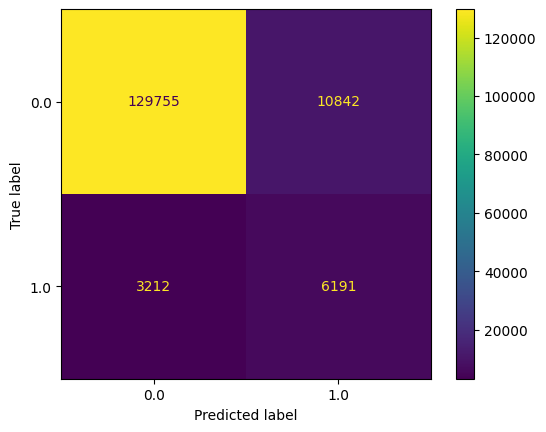

In [21]:
evaluate_model(trained_models['lgbmc'], X_test, y_test, threshold=0.8)


In [ ]:
# load model
with open('Model/trained_models.pcl', 'rb') as fd:
    trained_models = pickle.load(fd)

Accuracy: 0.9464733333333334
F1: 0.443010752688172
Precision: 0.6370710295291301
Recall: 0.3395724768690843
ROC AUC: 0.6633173948603549
AUC: 0.8741229851246646
Classification Report:               precision    recall  f1-score   support

   not churn       0.96      0.99      0.97    140597
       churn       0.64      0.34      0.44      9403

    accuracy                           0.95    150000
   macro avg       0.80      0.66      0.71    150000
weighted avg       0.94      0.95      0.94    150000

ROC Curve: (array([0.        , 0.01293769, 1.        ]), array([0.        , 0.33957248, 1.        ]), array([inf,  1.,  0.]))


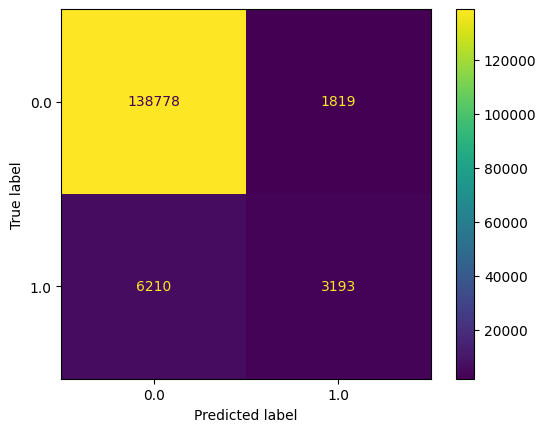

In [22]:
evaluate_model(trained_models['lgbmc_imb'], X_test, y_test)

In [ ]:
y_test.value_counts()

In [ ]:
evaluate_model(trained_models['lgbmc_imb'], X_test, y_test, threshold=0.8)

### let's create a model amsemble

In [ ]:
evaluate_model(trained_models['ensemble'], X_test, y_test, threshold=0.8)

In [ ]:
evaluate_model(trained_models['ensemble'], X_test, y_test)

In [ ]:
# let's make predictions using weighted ensemble
import numpy as np

def weighted_model_assembly(models, maes, X, y):
    """
    Perform weighted model assembly.

    Parameters:
    models (list): List of pre-trained models
    maes (list): List of Mean Absolute Errors corresponding to the models
    X (numpy.ndarray): Input features for prediction

    Returns:
    numpy.ndarray: Weighted predictions
    """
    # Calculate weights inversely proportional to MAE
    weights = np.array([1.0 / mae for mae in maes])
    weights /= np.sum(weights)  # Normalize weights

    # Initialize an array to store weighted predictions
    preds = np.zeros(X.shape[0])

    # Sum the weighted predictions from each model
    for (_, model), weight in zip(models, weights):
        predictions = model.predict_proba(X)[:, 1]
        preds += weight * predictions
    preds = (preds >= 0.5).astype(int)
    
    print(f'Accuracy: {accuracy_score(y, preds)}')
    print(f'F1: {f1_score(y, preds)}')
    print(f'Precision: {precision_score(y, preds)}')
    print(f'Recall: {recall_score(y, preds)}')
    print(f'ROC AUC: {roc_auc_score(y, preds)}')

    auc_score = roc_auc_score(y, model.predict_proba(X)[:,1])
    cm = confusion_matrix(y, preds, labels=model.classes_)
    print(f'AUC: {auc_score}')
    print(f'Classification Report: {classification_report(y, preds, target_names=["not churn", "churn"])}')
    print(f'ROC Curve: {roc_curve(y, preds)}')


    
    # Plot confusion matrix

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()

    # TP, FP, FN, TN = cm.ravel()
    # return TP, FP, FN, TN



def evaluate_models(models, X_train, X_val, y_train, y_val):
    # fit and evaluate the models
    scores = list()
    for name, model in models:
        # fit the model
        # model.fit(X_train, y_train)
        # evaluate the model
        yhat = model.predict(X_val)
        mae = mean_absolute_error(y_val, yhat)
        # store the performance
        scores.append(-mae)
        # report model performance
    return scores



In [ ]:
X_train.shape, y_train.shape

In [ ]:
models  = [
    ('xgboost', trained_models['xgboost']),
    ('lgbmc', trained_models['lgbmc']),
    ('rfc', trained_models['rfc']),
    ('lgbmc_imb', trained_models['lgbmc_imb'])

]
scores = evaluate_models(models, X_train_stratified, X_val_stratified, y_train_stratified, y_val_stratified)
# weighted_ensemble(trained_models, X_test, y_test)

In [ ]:
original_scores = scores.copy()
scores[1] = 0.5

In [ ]:
y_test[:1000].value_counts()

In [ ]:
# select 100 rows from X_test

weighted_model_assembly(models, scores.values(), X_test[:1000], y_test[:1000])

In [ ]:
# select 100 rows from X_test

weighted_model_assembly(models, scores, X_test[100:], y_test[100:])

In [ ]:
weighted_model_assembly(models, scores, X_test[100:], y_test[100:])